# Yolo-V9 for Orange Disease Detection


---


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat Jun 15 07:26:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 325 (delta 159), reused 156 (delta 156), pack-reused 107
Receiving objects: 100% (325/325), 2.23 MiB | 46.70 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.6 MB/s eta 0:00:00


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [4]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [5]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [6]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 Jun 15 07:28 .
drwxr-xr-x 1 root root      4096 Jun 15 07:28 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


## Download example data

**NOTE:** If you want to run inference using your own file as input, simply upload image to Google Colab and update `SOURCE_IMAGE_PATH` with the path leading to your file.

In [7]:
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [8]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"

## Detection with pre-trained COCO model

### gelan-c

In [9]:
!python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/gelan-c.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 467 layers, 25472640 parameters, 0 gradients, 102.8 GFLOPs
image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 handbag, 170.1ms
Speed: 0.4ms pre-process, 170.1ms inference, 828.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


**NOTE:** By default, the results of each subsequent inference sessions are saved in `{HOME}/yolov9/runs/detect/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

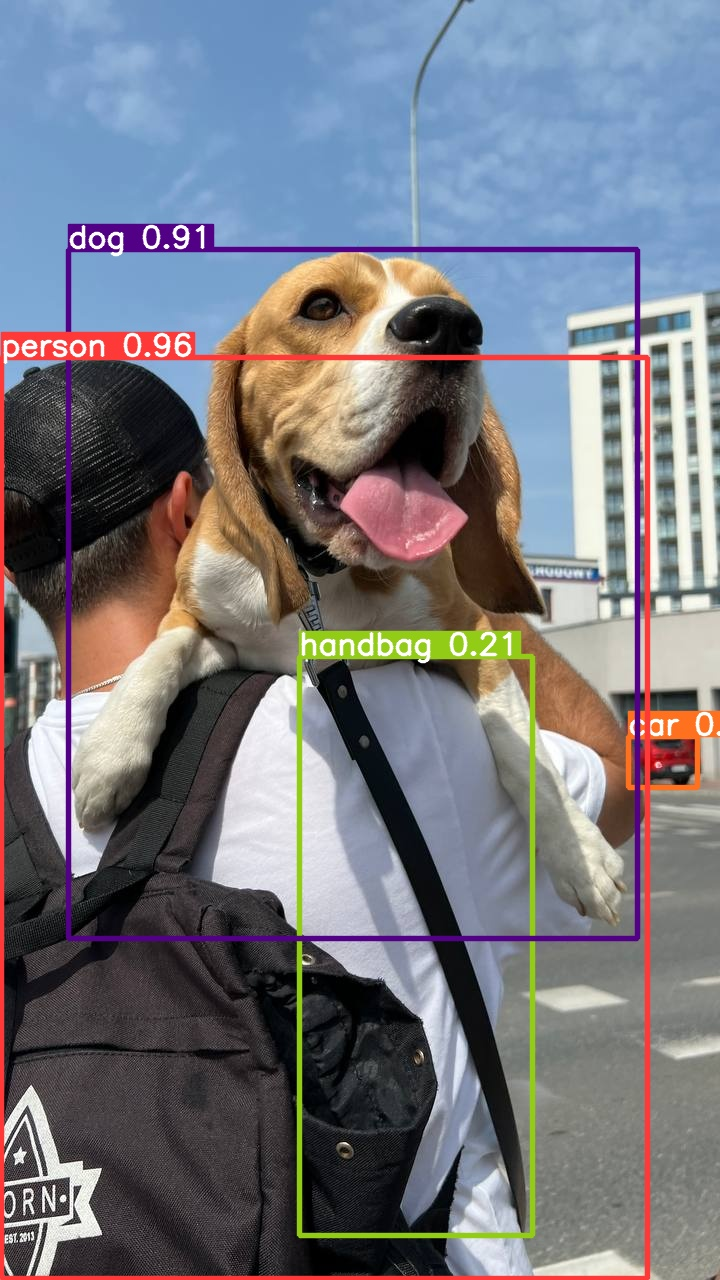

In [10]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp/dog.jpeg", width=600)

## yolov9-e

In [11]:
!python detect.py --weights {HOME}/weights/yolov9-e.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/yolov9-e.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 1119 layers, 69470144 parameters, 0 gradients, 244.0 GFLOPs
image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 backpack, 1 handbag, 228.8ms
Speed: 0.6ms pre-process, 228.8ms inference, 596.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


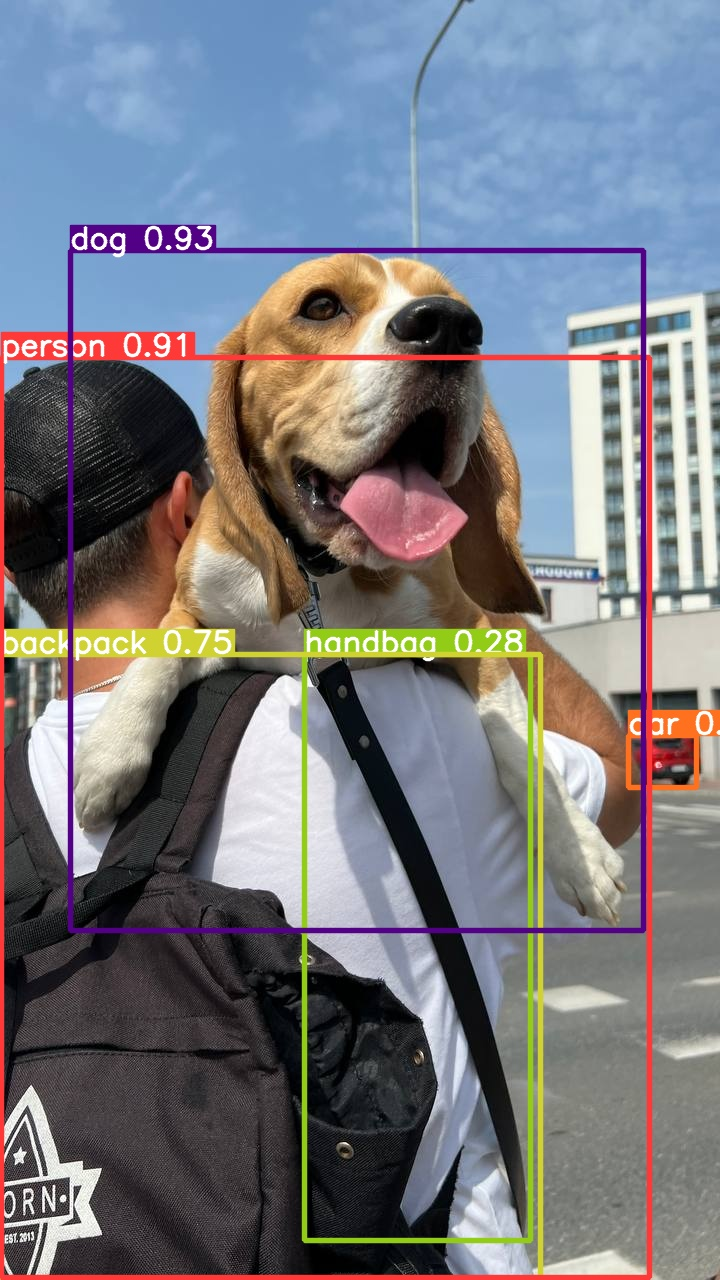

In [12]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp2/dog.jpeg", width=600)

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [13]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [14]:
!pip install roboflow
# don't change this code.
from roboflow import Roboflow
rf = Roboflow(api_key="nH3dBksu6XAxDwKZpKNV")
project = rf.workspace("oragne-disease-detection").project("orage-mdiwh")
version = project.version(1)
dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Orage-1 in yolov9:: 100%|██████████| 17830/17830 [00:02<00:00, 8034.66it/s]


## Train Custom Model

In [15]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 10 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-06-15 07:31:24.597626: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 07:31:24.649120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 07:31:24.649174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 07:31:24.650717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 07:31:24.658639: I tensorflow/core/platform/

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [16]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1718436686.44191adfa30a.2499.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


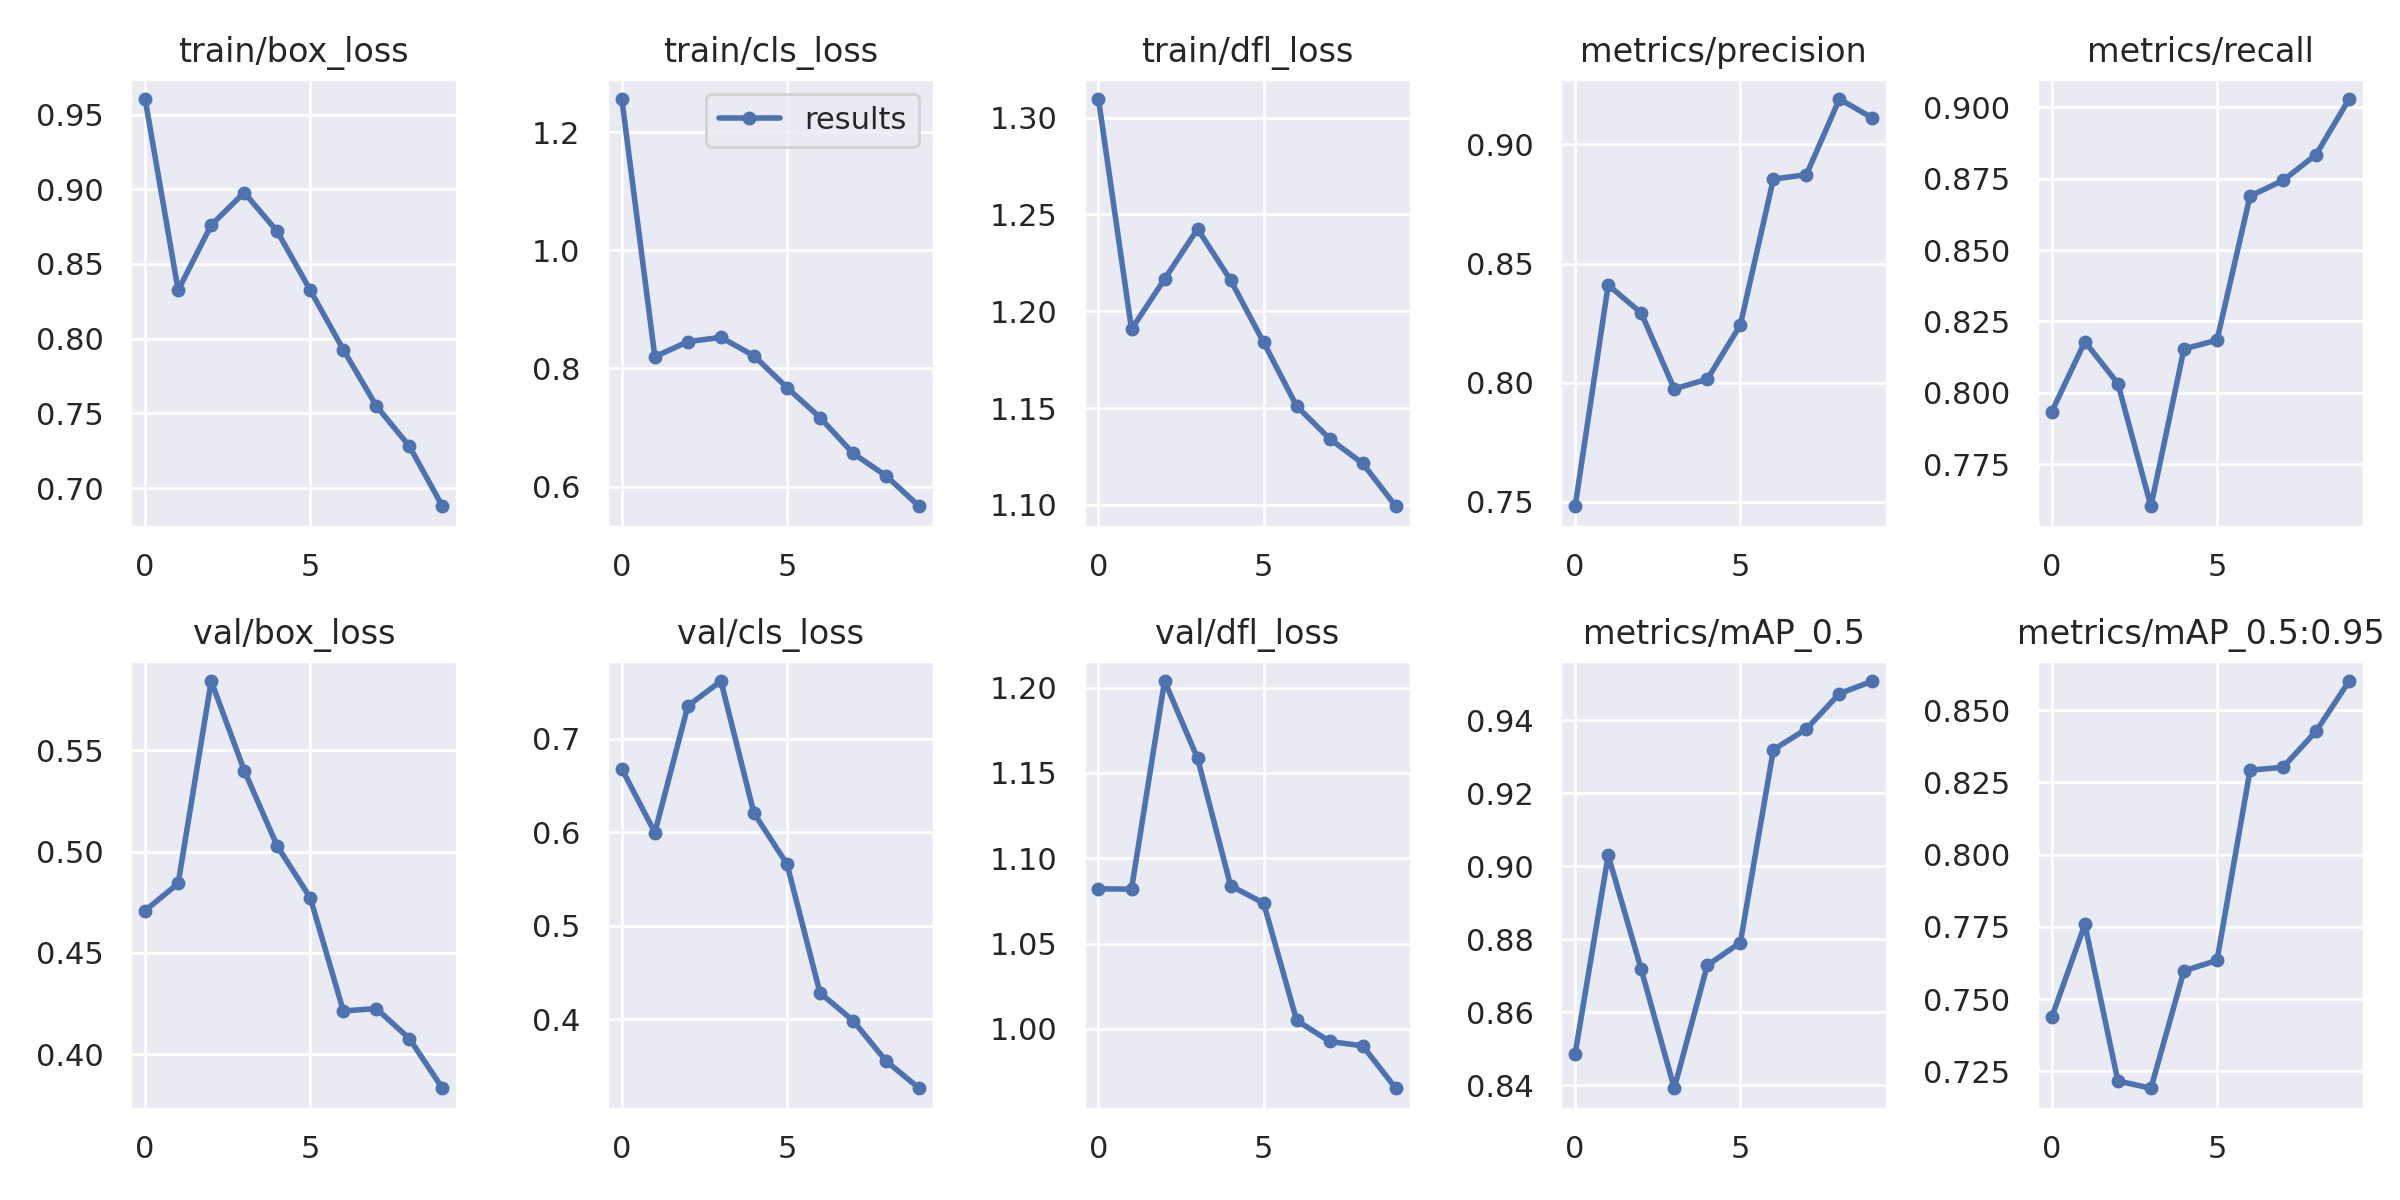

In [17]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

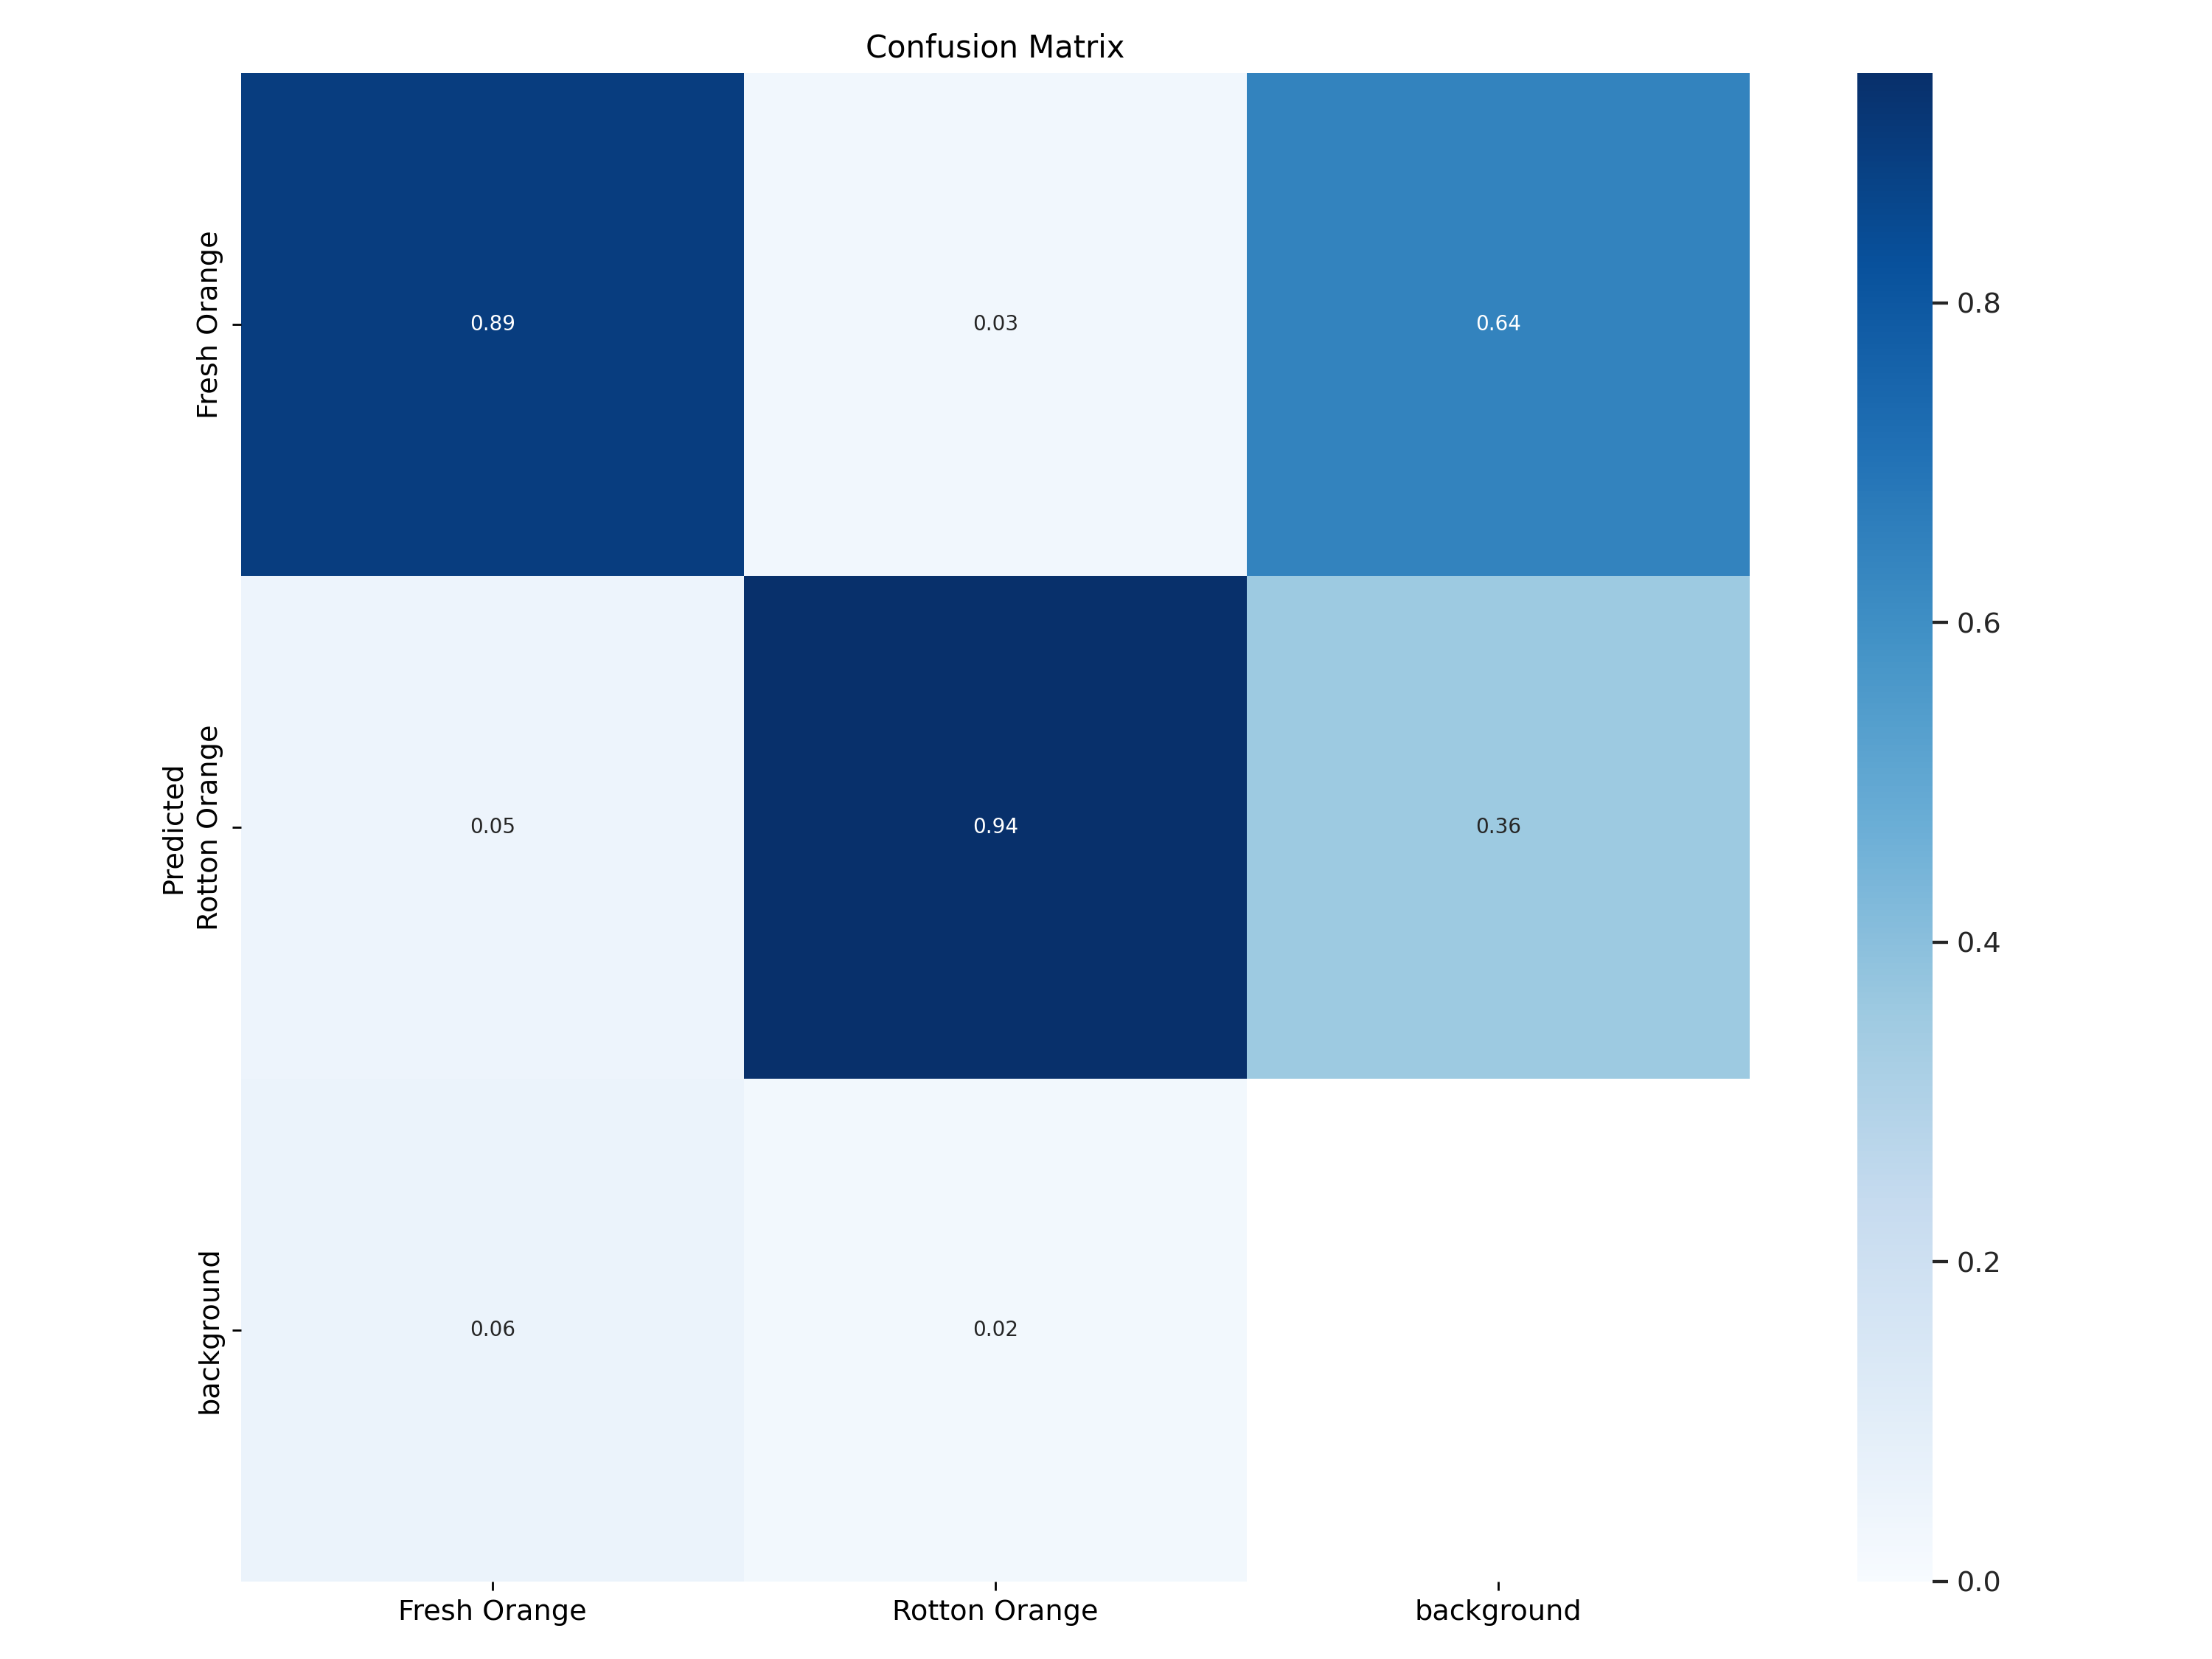

In [18]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

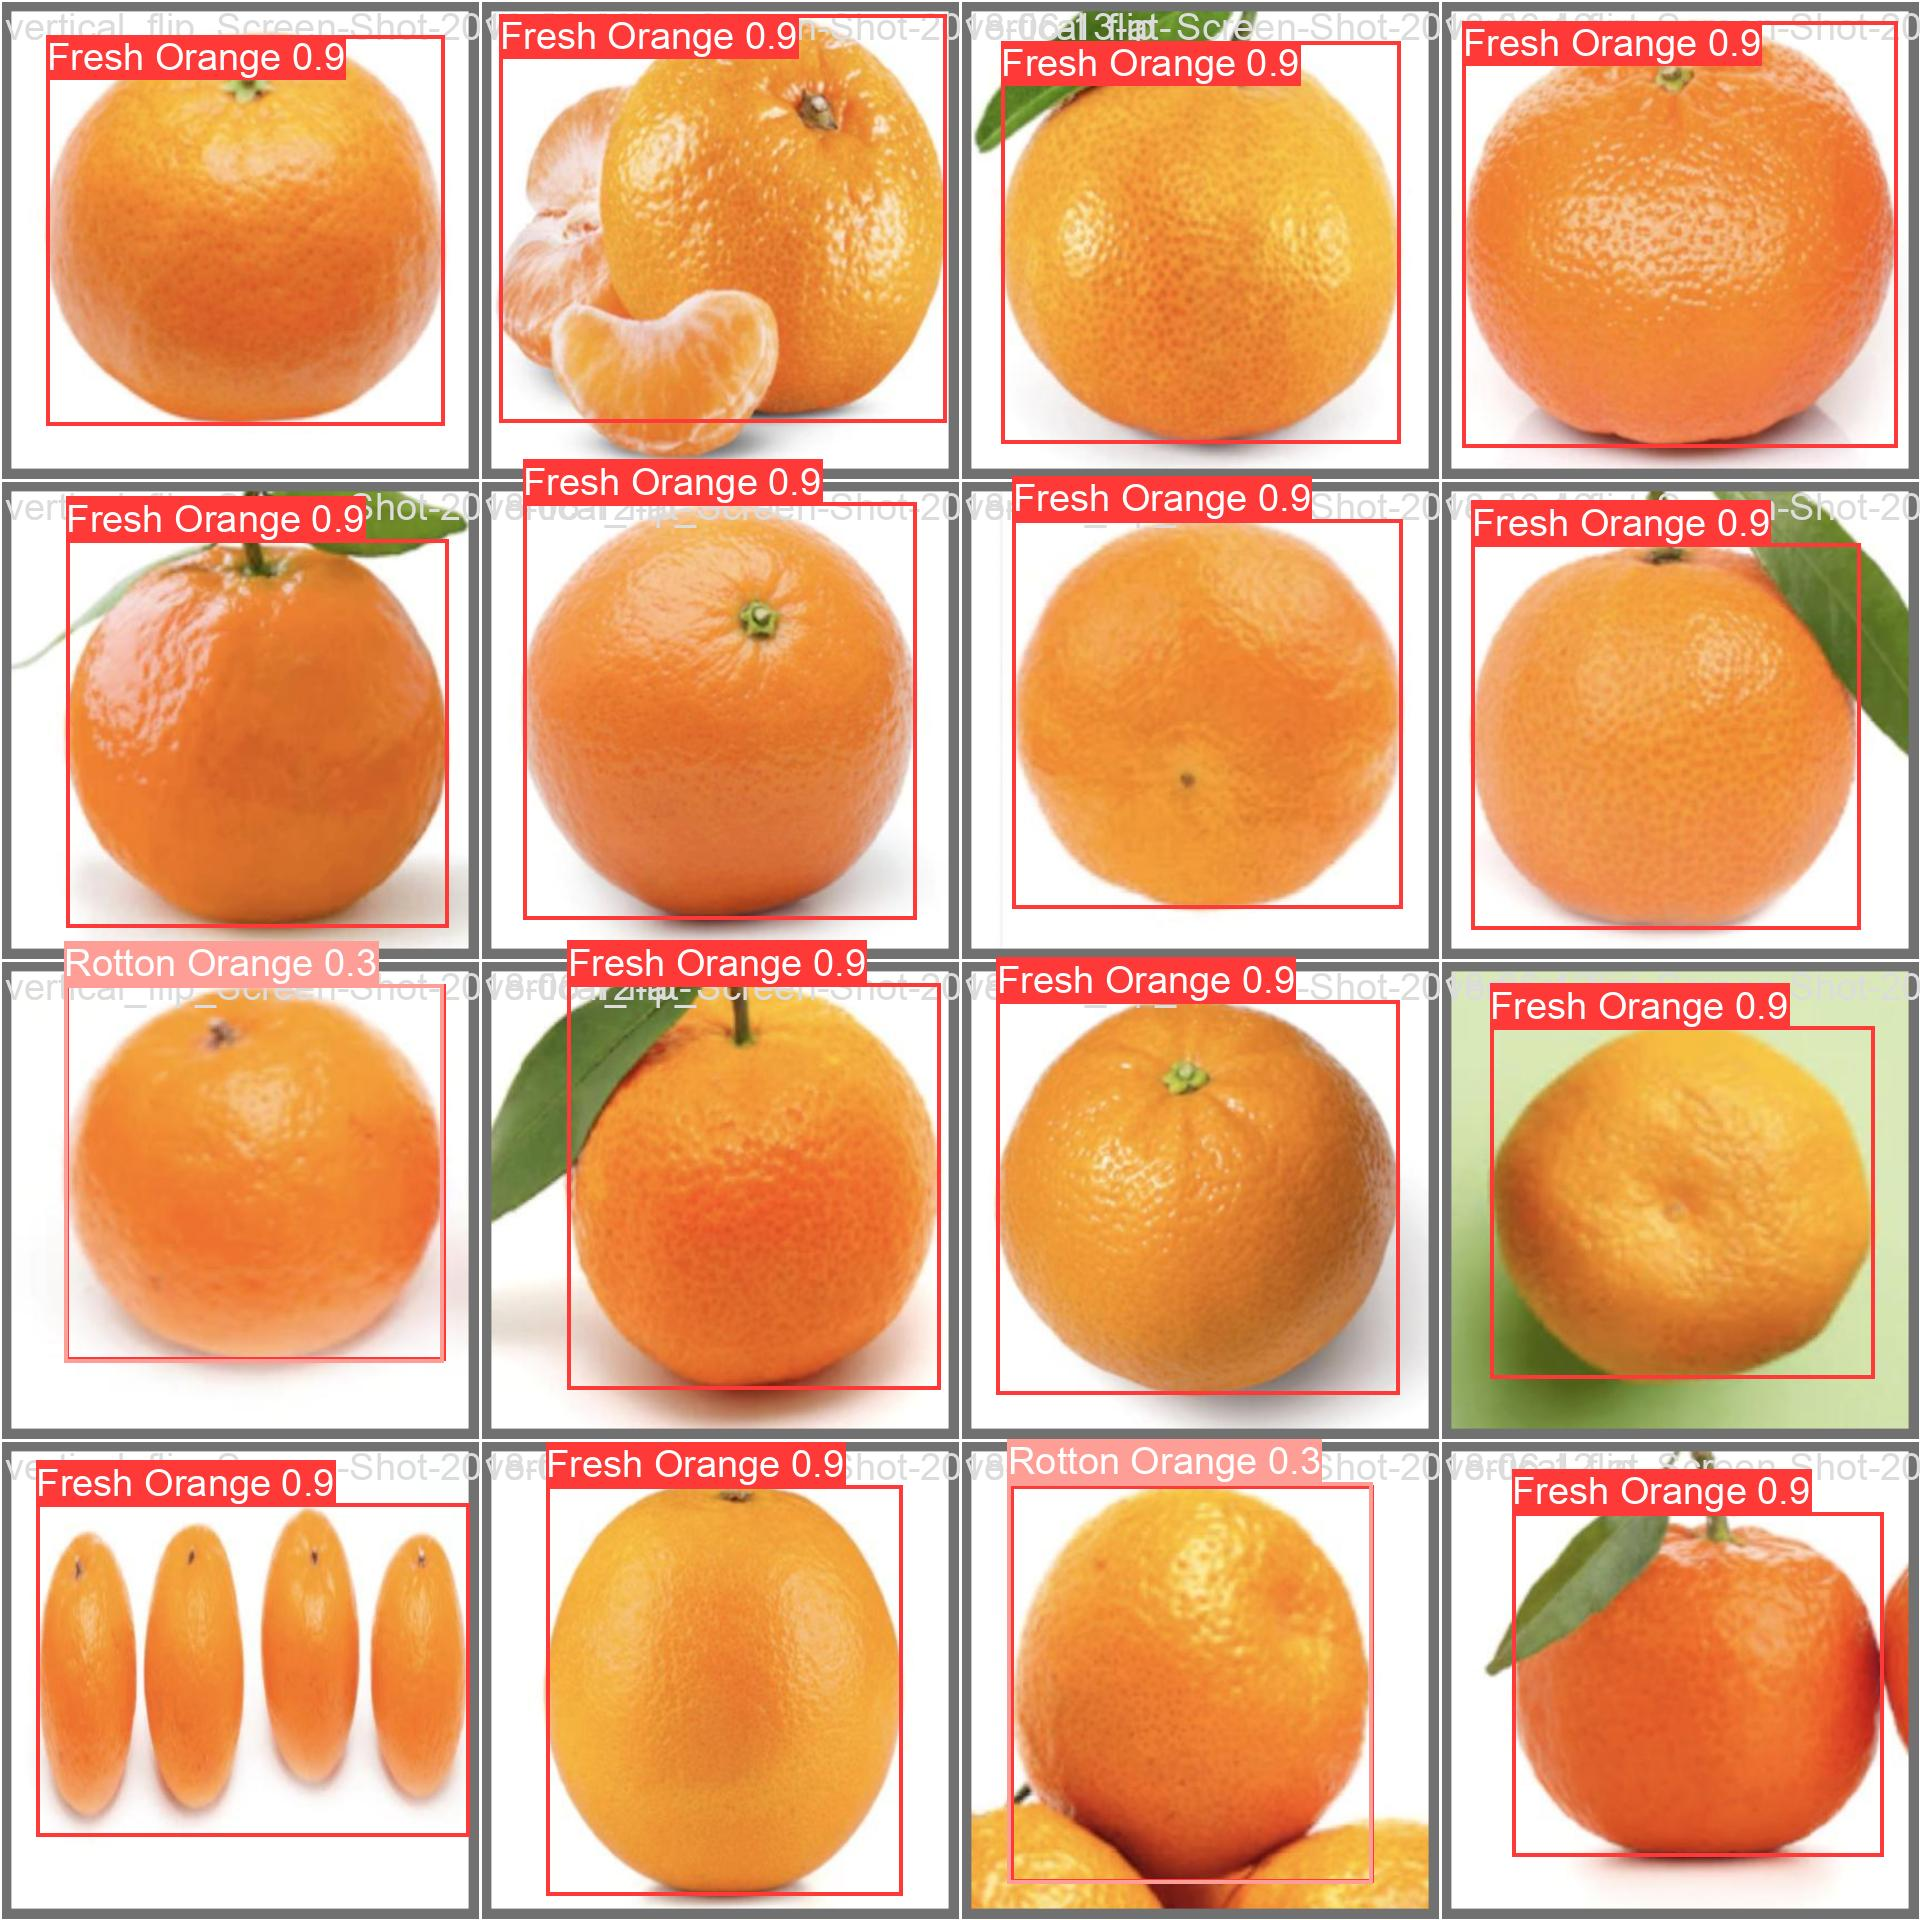

In [19]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [20]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/Orage-1/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25412502 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/Orage-1/valid/labels.cache... 1178 images, 0 backgrounds, 0 corrupt: 100% 1178/1178 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 37/37 [00:16<00:00,  2.27it/s]
                   all       1178       1766      0.911      0.903      0.951       0.86
          Fresh Orange       1178        891    

## Inference with Custom Model

In [21]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/yolov9/Orage-1/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25412502 parameters, 0 gradients, 102.5 GFLOPs
image 1/605 /content/yolov9/Orage-1/test/images/1004_jpg.rf.655d855927a2ca7752cd576216e42686.jpg: 1280x1280 6 Fresh Oranges, 17.3ms
image 2/605 /content/yolov9/Orage-1/test/images/1052_jpg.rf.a610295f13f71a43e7e336af5d88f179.jpg: 1280x1280 7 Fresh Oranges, 2 Rotton Oranges, 19.1ms
image 3/605 /content/yo

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

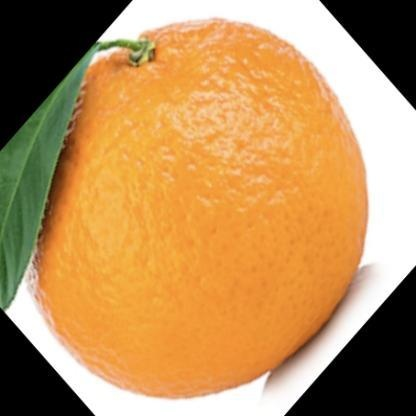

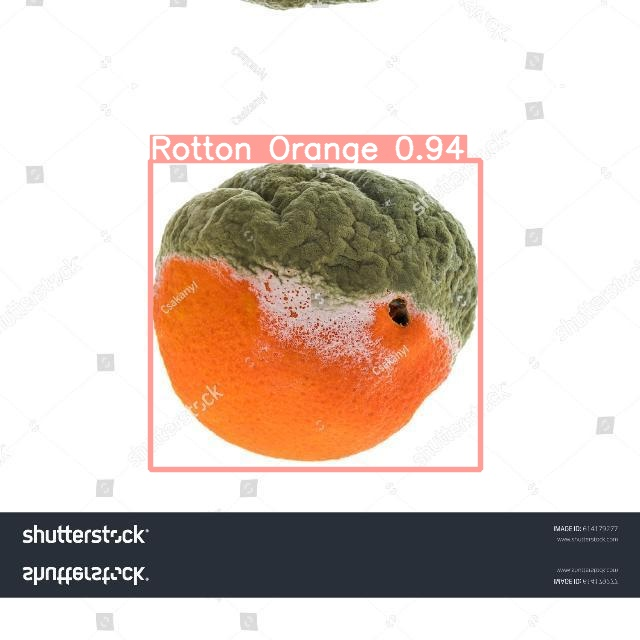

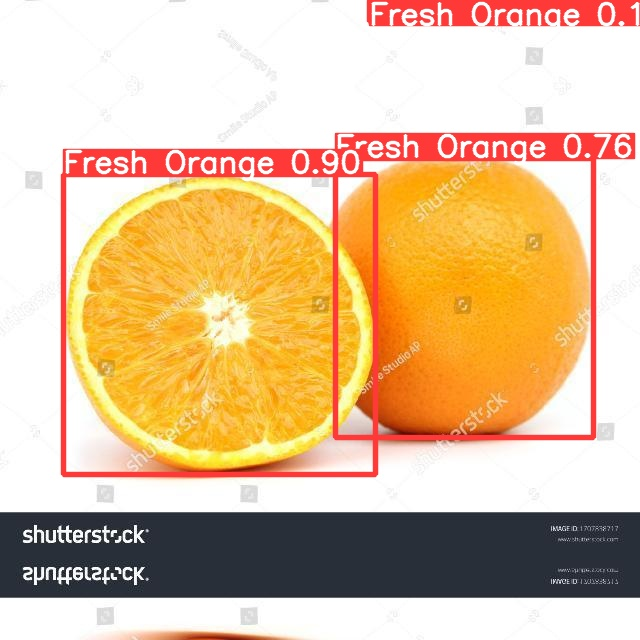

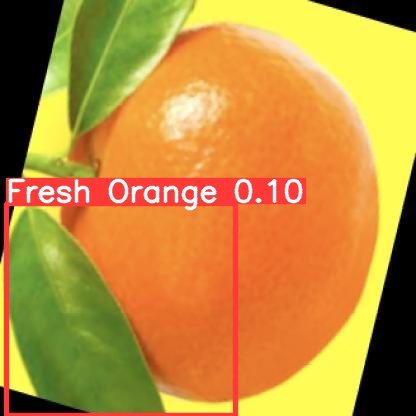

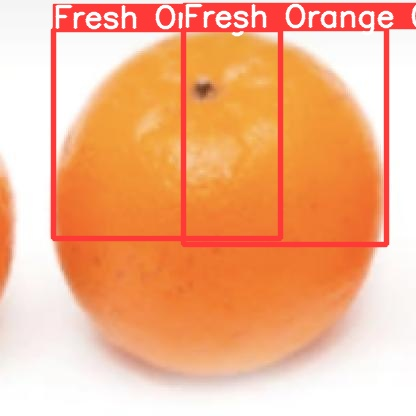

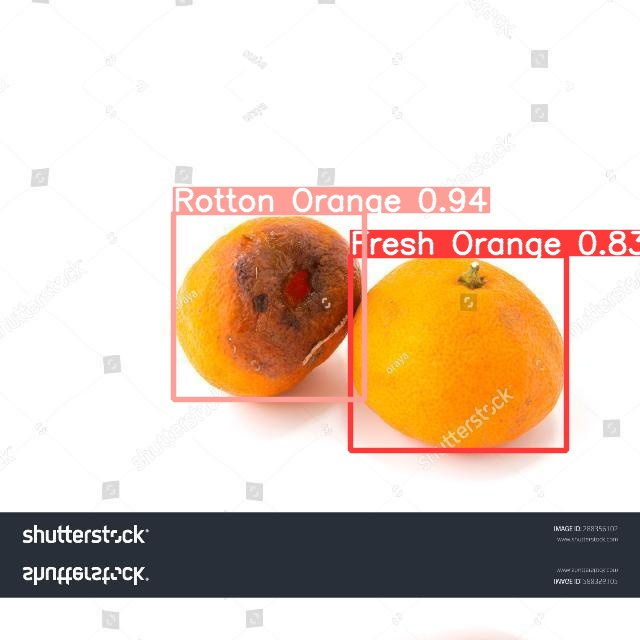

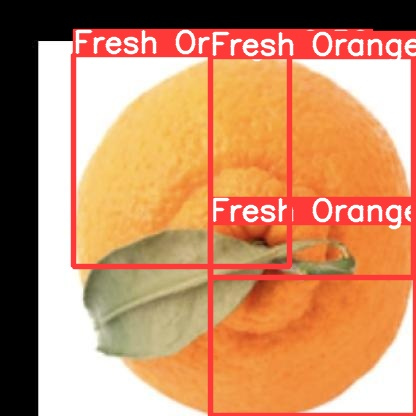

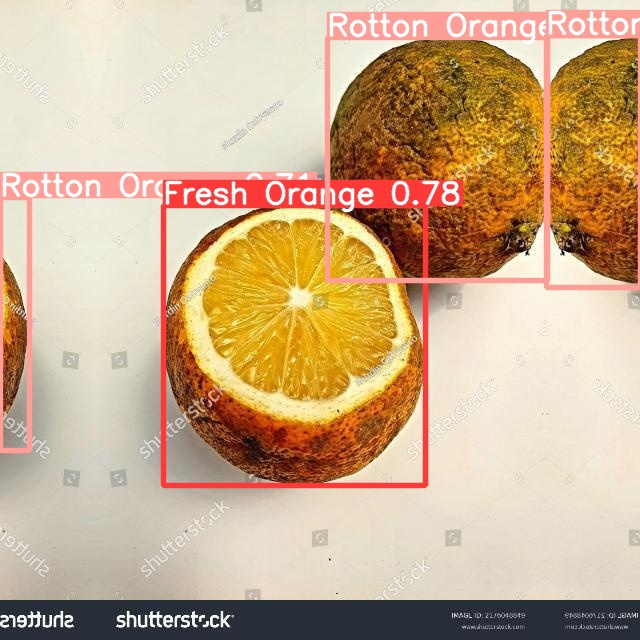

In [23]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp3/*.jpg')[102:110]:
      display(Image(filename=image_path, width=600))